# SpectrogramList and SpectrogramDict Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/intro_spectrogram.ipynb)

This notebook introduces the newly added `SpectrogramList` and `SpectrogramDict` classes in `gwexpy`.

These classes are containers for managing multiple spectrogram data (`gwpy.spectrogram.Spectrogram`) collectively and performing batch operations (cropping, rebinning, plotting, etc.).
They have a similar interface to `TimeSeriesList` / `TimeSeriesDict` which handle time series data, but are specialized for 2D data (time × frequency).

In [1]:
import matplotlib.pyplot as plt

from gwexpy.noise.wave import gaussian, sine
from gwexpy.spectrogram import SpectrogramDict, SpectrogramList

## 1. Data Preparation

First, let's create demo spectrogram data.
Here, we generate time series data containing sine waves at different frequencies and convert them using the `spectrogram()` method.

In [2]:
# Create sample data
duration = 20  # seconds
sample_rate = 128  # Hz

# Create sine waves at 10Hz, 30Hz, 50Hz (+noise)
noise_amp = 0.1


def make_signal(freq, name):
    s = sine(duration=duration, sample_rate=sample_rate, frequency=freq, amplitude=1.0)
    n = gaussian(duration=duration, sample_rate=sample_rate, std=noise_amp)
    ts = s + n
    ts.name = name
    ts.override_unit("strain")
    return ts


ts1 = make_signal(10, "Signal 10Hz")
ts2 = make_signal(30, "Signal 30Hz")
ts3 = make_signal(50, "Signal 50Hz")

# Calculate spectrograms (stride=2s, fftlength=1s)
# Specify nproc=1 for stability with serial execution
spec1 = ts1.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)
spec2 = ts2.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)
spec3 = ts3.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)

print("Spectrogram shape:", spec1.shape)
print("Time range:", spec1.xspan)
print("Freq range:", spec1.yspan)

Spectrogram shape: (10, 65)
Time range: [0.0 ... 20.0)
Freq range: [0.0 ... 65.0)


## 2. Basic Operations with SpectrogramList

`SpectrogramList` behaves like a list, but can only store `Spectrogram` objects.
You can pass a list during initialization or add items using the `append()` method.

In [3]:
# Create a list
spec_list = SpectrogramList([spec1, spec2])

# Append
spec_list.append(spec3)

print(f"List length: {len(spec_list)}")
print(f"Items: {[s.name for s in spec_list]}")

List length: 3
Items: ['Signal 10Hz', 'Signal 30Hz', 'Signal 50Hz']


### Batch Processing: Cropping Time Axis (`crop`)

Performs batch cropping of the time axis for all spectrograms in the list.
**Note:** Since spectrograms have large data volumes, operations like cropping may return new objects (copies) without modifying the original data.

In [4]:
# Crop to 5-15 second range
cropped_list = spec_list.crop(5, 15)

print("Original range:", spec_list[0].xspan)
print("Cropped range:", cropped_list[0].xspan)

Original range: [0.0 ... 20.0)
Cropped range: [4.0 ... 14.0)


### Batch Processing: Cropping Frequency Axis (`crop_frequencies`)

If there's a compatible method in gwpy's `Spectrogram`, it will be used; otherwise, filtering is performed by specifying the frequency axis.

In [5]:
# Crop to 0Hz - 40Hz range
freq_cropped = spec_list.crop_frequencies(0, 40)

print("Original yspan:", spec_list[0].yspan)
print("Cropped yspan:", freq_cropped[0].yspan)
# The third element containing the 50Hz signal will also have out-of-range portions cut

Original yspan: [0.0 ... 65.0)
Cropped yspan: [0.0 ... 40.0)


## 3. Using SpectrogramDict

`SpectrogramDict` is convenient when you want to manage spectrograms with names (keys).

In [6]:
spec_dict = SpectrogramDict({"low_freq": spec1, "mid_freq": spec2, "high_freq": spec3})

print("Keys:", list(spec_dict.keys()))

Keys: ['low_freq', 'mid_freq', 'high_freq']


## 4. Visualization (`plot`)

Calling the `.plot()` method on a list or dictionary allows you to plot all contained spectrograms together.
Internally, it uses `gwpy.plot.Plot`.

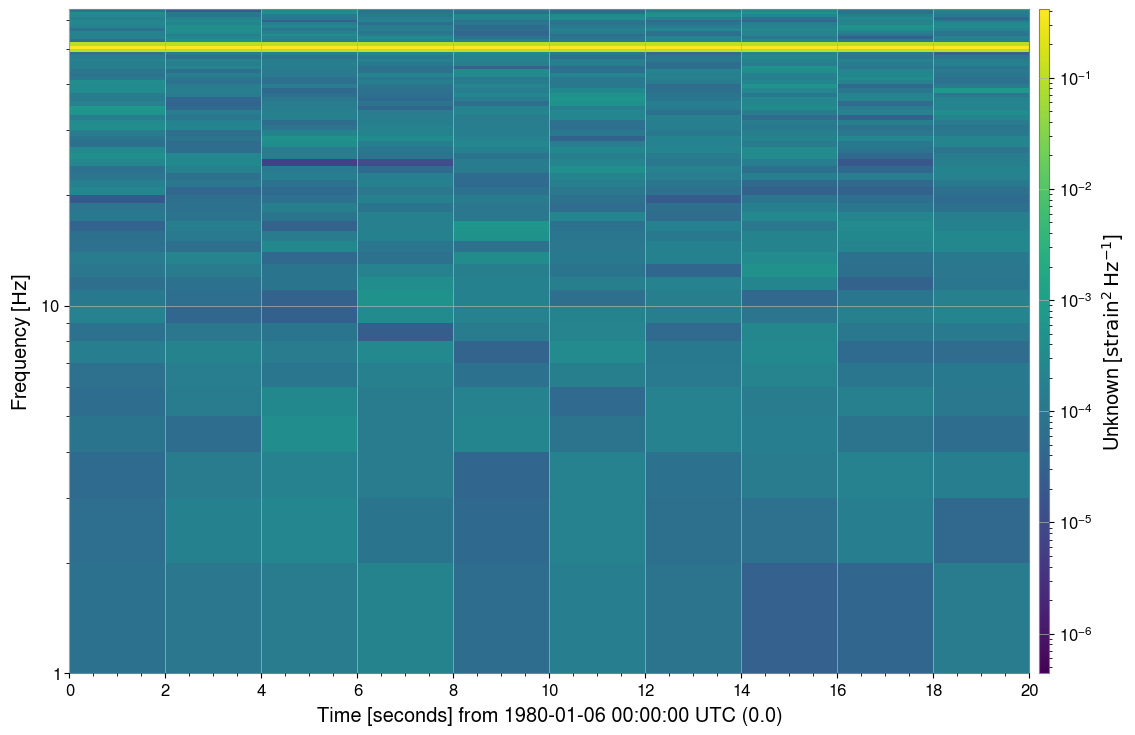

In [7]:
# Batch plotting
# Setting sharex=True, sharey=True shares axes for easier comparison
plot = spec_dict.plot(figsize=(12, 8), sharex=True, sharey=True)
plt.show()

## 5. Conversion to Matrix Format and Deep Learning Integration

Using `to_matrix()`, you can create a `SpectrogramMatrix` object with a 3D array `(Channels, Time, Frequency)` that stacks each spectrogram.

This is very convenient when creating inputs for machine learning models (PyTorch, TensorFlow, etc.).

In [8]:
matrix = spec_list.to_matrix()

print("Matrix Type:", type(matrix))
print("Matrix Shape:", matrix.shape)
print("  (N_channels, N_time_steps, N_freq_bins)")

# Accessing attributes
print("Time axis shape:", matrix.times.shape)
print("Freq axis shape:", matrix.frequencies.shape)

Matrix Type: <class 'gwexpy.spectrogram.matrix.SpectrogramMatrix'>
Matrix Shape: (3, 10, 65)
  (N_channels, N_time_steps, N_freq_bins)
Time axis shape: (10,)
Freq axis shape: (65,)


If PyTorch or CuPy is installed, you can directly convert to Tensors, etc.

```python
# Convert to PyTorch Tensor
# tensor = matrix.to_torch()
```

## Summary

This concludes the introduction to the basic usage of `SpectrogramList` and `SpectrogramDict`.
Please make use of these classes when batch preprocessing large amounts of spectrogram data or creating comparison plots.